In [1]:
#Importation of libraries used for this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,precision_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")



%matplotlib inline

In [2]:
#importation of the dataset
bank_data =pd.read_csv('cust_seg.csv')

## Data Cleaning and Formating

In [3]:
bank_data.shape

(850, 10)

In [4]:
bank_data.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [5]:
#lets drop the unnamed column from the data since it's not informative and it's very similar to the customer Id
bank_data.drop('Unnamed: 0', inplace = True,axis=1)

In [6]:
bank_data.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


From the snapshot of the data above, we can see that there are some missing values in the defaulted column. we can also note that we only have numerical variables

In [7]:
#brief summary on the numerical attributes
bank_data.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


One of the noticable columns is one for income, there is some bit of skewness in this column. we shall need to address this at some point.We can see that the dataset is mostly made up of medium aged young people of average age about 35 years.

In [8]:
#Lets fill in the missing values in the defaulted column with the median
bank_data['Defaulted'] = bank_data.Defaulted.fillna(value=bank_data.Defaulted.median)

In [9]:
#code shows no more missing values.
bank_data.Defaulted.isnull().any()

False

## Explanatory data analysis

Lets perform some data visualization for some  numerical variables of interest

In [10]:
num_features =['Age','Edu','Years Employed','Income','Card Debt','DebtIncomeRatio']

In [11]:
num_data = bank_data[num_features]

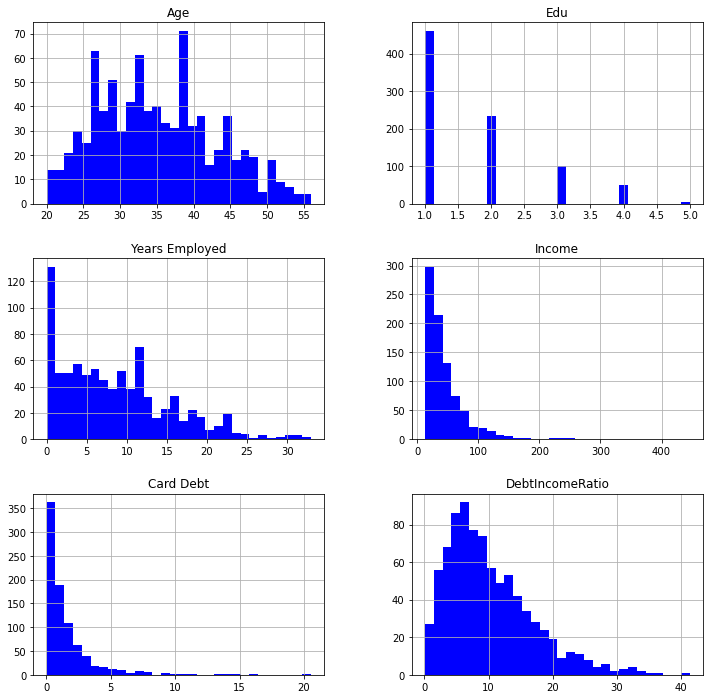

In [12]:
# Plotting histograms plots for the variables
num_data.hist(bins=30, color = 'blue',figsize=(12,12))
plt.savefig('Histogram_image1.png')
plt.show()

From the look at the histograms, there are some columns that are skewed.

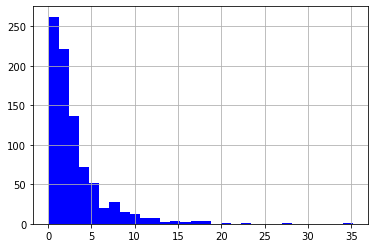

In [13]:
# Plotting Histogram  for the Other debt variable
bank_data['Other Debt'].hist(bins=30, color = 'blue',figsize=(6,4))
plt.show()

Plot above shows that the other debt variable is skewed to the right.we will remove the skewness from the variable before clustering.

In [14]:
#feature engineering 
#lets create a new feature Total_Debt from Card Debt and Other Debt
bank_data['Total_Debt'] = bank_data['Card Debt'] + bank_data['Other Debt']

In [15]:
#snap shot of the data
bank_data.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total_Debt
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1.197
1,2,47,1,26,100,4.582,8.218,0.0,12.8,12.800
2,3,33,2,10,57,6.111,5.802,1.0,20.9,11.913
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1.197
4,5,47,1,31,253,9.308,8.908,0.0,7.2,18.216


In [16]:
bank_data.skew()

Customer Id        0.000000
Age                0.335037
Edu                1.216846
Years Employed     0.862663
Income             3.700761
Card Debt          3.701790
Other Debt         3.206006
DebtIncomeRatio    1.124999
Total_Debt         3.159446
dtype: float64

From the code above, we can see some columns which are more skewed than others. we are going to reduce skewness in the Total debt, income  and Age  columns since they are the features that we are going to use for clustering . 

Our goal is to Segment our customers into favourable clusters
We are going to make use of  variables; Age, Income and Total Debt
We shall make use of the Kmeans clustering model to perform the segmentation.
For better performance of the model,we shall need to scale and standardize the data of the columns of  interest

## Creating Clusters

In [17]:
cluster_columns = ['Age','Income','DebtIncomeRatio','Edu','Years Employed']
cluster_df = bank_data[cluster_columns]

In [18]:
cluster_df.head()

,Age,Income,DebtIncomeRatio,Edu,Years Employed
0,41,19,6.3,2,6
1,47,100,12.8,1,26
2,33,57,20.9,2,10
3,29,19,6.3,2,4
4,47,253,7.2,1,31


In [19]:
scalar=StandardScaler()
scaled_df = scalar.fit_transform(cluster_df)

In [20]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,-0.205665,0.126879
1,3.119430,-1.060459
2,0.104293,0.429401
3,-1.201972,0.283491
4,5.898378,-0.329465
...,...,...
845,-1.189265,-0.697172
846,-0.782296,0.285358
847,-1.889875,2.740929
848,-0.180677,-1.009616


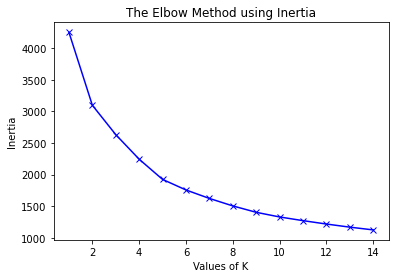

In [21]:
inertia = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pd.DataFrame(scaled_df))
    inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [22]:
kmeans_model=KMeans(3)
kmeans_model.fit_predict(scaled_df)
pca_df_kmeans= pd.concat([pca_df,pd.DataFrame({'cluster':kmeans_model.labels_})],axis=1)

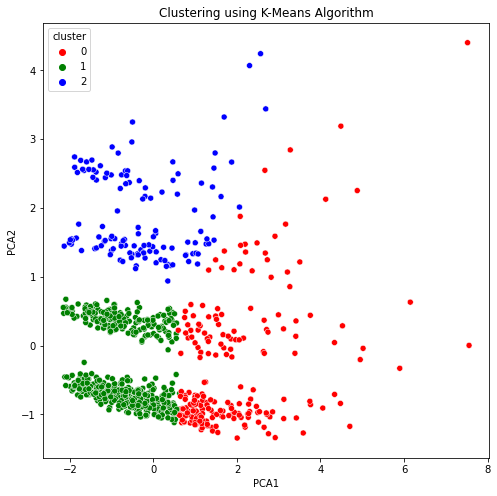

In [23]:
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans,palette=['red','green','blue'])
plt.title("Clustering using K-Means Algorithm")
plt.savefig('cluster_image.png')
plt.show()

We can see that three definate clusters are generated.

In [24]:
# find all cluster centers
cluster_centers = pd.DataFrame(data=kmeans_model.cluster_centers_,columns=[cluster_df.columns])
# inverse transform the data
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers,columns=[cluster_df.columns])
cluster_centers

,Age,Income,DebtIncomeRatio,Edu,Years Employed
0,43.266355,85.032710,9.571495,1.528037,17.252336
1,31.820513,30.319527,10.186588,1.349112,5.741617
2,33.976744,47.325581,11.108527,3.434109,5.255814


In [25]:
# Creating a target column "Cluster" for storing the cluster segment
final_df = pd.concat([cluster_df,pd.DataFrame({'Cluster':kmeans_model.labels_})],axis=1)
final_df.head()

,Age,Income,DebtIncomeRatio,Edu,Years Employed,Cluster
0,41,19,6.3,2,6,1
1,47,100,12.8,1,26,0
2,33,57,20.9,2,10,1
3,29,19,6.3,2,4,1
4,47,253,7.2,1,31,0


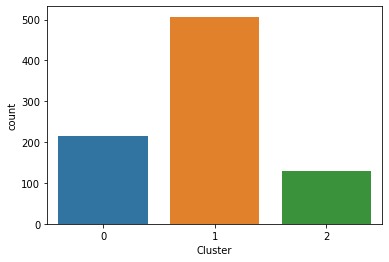

In [26]:
#Visualization
%matplotlib inline
sns.countplot(x='Cluster', data=final_df)
plt.show()

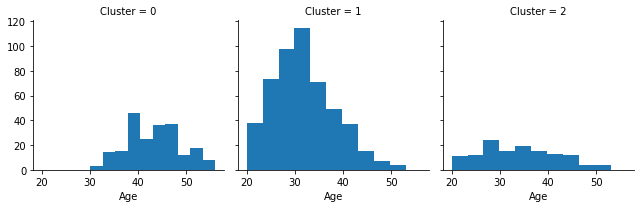

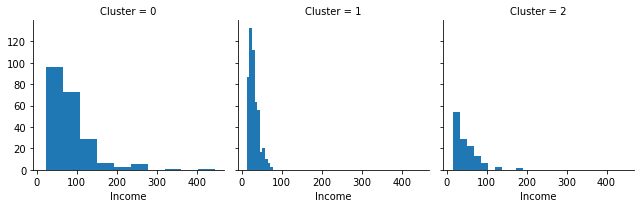

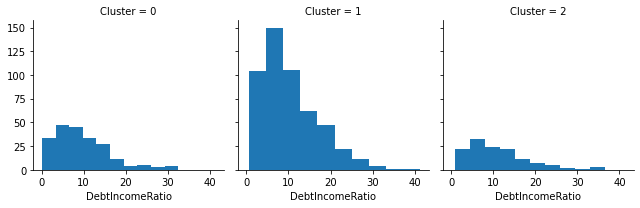

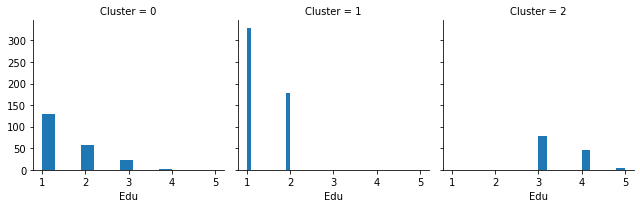

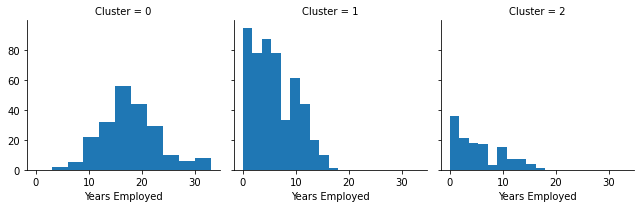

In [27]:
for c in final_df.drop(['Cluster'],axis=1):
    grid= sns.FacetGrid(final_df, col='Cluster')
    grid= grid.map(plt.hist, c)
plt.show()

In [28]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmeans_model, "kmeans_model.pkl")

['kmeans_model.pkl']

In [29]:
final_df.to_csv("Clustered_Customer_Data.csv")

In [30]:
#Split Dataset
X = final_df.drop(['Cluster'],axis=1)
y= final_df[['Cluster']]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3)

In [31]:
X_train.head()

,Age,Income,DebtIncomeRatio,Edu,Years Employed
555,50,21,12.9,1,6
75,33,18,12.9,1,5
99,22,20,4.7,3,0
80,33,68,10.8,1,12
700,36,20,8.1,5,5


In [32]:
y_train.head()

,Cluster
555,1
75,1
99,2
80,1
700,2


## Model Building and Evaluation

In [33]:
LOG_R_clf = LogisticRegression()
LOG_R_clf.fit(X_train, y_train)
y_pred_LR = LOG_R_clf.predict(X_test)
LOG_R_score=LOG_R_clf.score(X_train,y_train)*100
print("The Logistic Regression train Accuracy = {:.2f}".format(LOG_R_score))

The Logistic Regression train Accuracy = 92.44


In [34]:
SVC_clf = SVC()
SVC_clf.fit(X_train, y_train)
y_pred_SVC = SVC_clf.predict(X_test)
SVC_score =SVC_clf.score(X_train,y_train)*100
print("The SVC train Accuracy = {:.2f}".format(SVC_score))

The SVC train Accuracy = 83.70


In [35]:
KNN_clf = KNeighborsClassifier(n_neighbors = 3)
KNN_clf.fit(X_train, y_train)
y_pred_KNN = KNN_clf.predict(X_test)
KNN_score =KNN_clf.score(X_train,y_train)*100
print("The KNeighbors Classifier train Accuracy = {:.2f}".format(KNN_score))

The KNeighbors Classifier train Accuracy = 90.92


In [36]:
RF_clf = RandomForestClassifier(n_estimators=100)
RF_clf.fit(X_train, y_train)
prediction_train= RF_clf.predict(X_train)
y_pred_RF = RF_clf.predict(X_test)
RF_score=RF_clf.score(X_train,y_train)*100
print("The Random Forest train Accuracy = {:.2f}".format(RF_score))

The Random Forest train Accuracy = 100.00


In [37]:
GB_clf = GradientBoostingClassifier(n_estimators=100)
GB_clf.fit(X_train,y_train)
y_pred_GB = GB_clf.predict(X_test)
GB_score=GB_clf.score(X_train,y_train)*100
print("Gradient Boosting Classifier train Accuracy = {:.2f}".format(GB_score))

Gradient Boosting Classifier train Accuracy = 100.00


<Figure size 720x576 with 0 Axes>

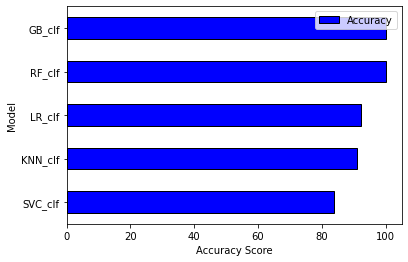

In [38]:
fig = plt.figure(figsize=(10,8))

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['LR_clf', 'SVC_clf',
                                           'KNN_clf', 'RF_clf',
                                            'GB_clf'],
                                 'Accuracy': [LOG_R_score,SVC_score,KNN_score,RF_score,GB_score ]})

# Horizontal bar chart of train accuracy
model_comparison.sort_values('Accuracy').plot(x = 'model', y = 'Accuracy', 
                                kind = 'barh',color = 'blue', edgecolor = 'black')
# Plot formatting
plt.ylabel('Model'); plt.yticks(size = 10); plt.xlabel('Accuracy Score'); plt.xticks(size = 10)
plt.savefig('modal_image1.png')
plt.show()

The random forest model and gradient boosting models seem to have similar results, lets see their purpose in the confusion matrix

In [39]:
#Confusion_Matrix for random forest
print(metrics.confusion_matrix(y_test, y_pred_GB))
print(classification_report(y_test, y_pred_GB))

[[ 57   6   1]
 [  0 147   0]
 [  1   0  43]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        64
           1       0.96      1.00      0.98       147
           2       0.98      0.98      0.98        44

    accuracy                           0.97       255
   macro avg       0.97      0.96      0.96       255
weighted avg       0.97      0.97      0.97       255



In [40]:
#Confusion_Matrix for random forest
print(metrics.confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))

[[ 61   3   0]
 [  1 146   0]
 [  0   0  44]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        64
           1       0.98      0.99      0.99       147
           2       1.00      1.00      1.00        44

    accuracy                           0.98       255
   macro avg       0.99      0.98      0.98       255
weighted avg       0.98      0.98      0.98       255



The random forest  model produced a slightly better overall accuracy

### Model Saving 

In [41]:
import pickle
filename = 'final_model.sav'
pickle.dump(RF_clf, open(filename, 'wb'))
 
#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result,'% Acuuracy')

0.9686274509803922 % Acuuracy
